# Code to compare train and test stage of DL model


In [1]:
import os
import sys
import numpy as np
import pandas as pd
import pickle
import re
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../')
from lib.io_utils import *

In [2]:
project_dir = '../'
exp_dir = '{}pilot_experiments/'.format(project_dir)
results_dir = '{}results/Exp_kaggle/'.format(exp_dir)

In [3]:
# experiment_names = ['Exp_pytorch_cifar','Exp_kaggle_mateuszbuda','Exp_kaggle_mateuszbuda_pruned']
exp_idx = range(1,16)
experiment_names = ['Exp_kaggle_mateuszbuda_{}'.format(i) for i in exp_idx] #['Exp_kaggle_mateuszbuda','Exp_kaggle_mateuszbuda_pruned']

devices = ['cuda'] 

jcols = ['experiment_name','device','tag','duration','package_total','dram_total','nvidia_total','process_total']
exp_config_df_concat = pd.DataFrame()
epoch_df_concat = pd.DataFrame()
joules_df_concat = pd.DataFrame()
for exp_name in experiment_names:
    for device in devices:
        exp_config_csv = '{}{}/{}/experiment_config.csv'.format(results_dir,exp_name,device)
        epoch_csv = '{}{}/{}/epoch.csv'.format(results_dir,exp_name,device)
        iter_csv = '{}{}/{}/iter.csv'.format(results_dir, exp_name, device)
        joules_csv = '{}{}/{}/joules.csv'.format(results_dir,exp_name,device)

        # Calculate how many times model was saved (i/o)
        # Consistently large ops for small batch sizes, but pretty similar across model sizes - does not explain joules preformance. 
        iter_df = pd.read_csv(iter_csv)
        model_save_ops = np.sum(iter_df['valid_loss'].diff() < 0)

        exp_config_df = pd.read_csv(exp_config_csv)
        exp_config_df['model_save_ops'] = model_save_ops

        exp_config_df_concat = exp_config_df_concat.append(exp_config_df)

        epoch_df = pd.read_csv(epoch_csv)
        epoch_df['experiment_name'] = exp_name
        epoch_df['device'] = device
        epoch_df_concat = epoch_df_concat.append(epoch_df)

        joules_df = read_joules(joules_csv,device)
        joules_df['experiment_name'] = exp_name        
        joules_df_concat = joules_df_concat.append(joules_df[jcols])


exp_config_df_concat.head()

,MAC,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,arch,batch_size,count,device,experiment_compute_time,...,n_epochs,optimizer,params,proc,python_version,test_compute_time,test_perf,test_perf_selected,train_compute_time,valid_perf_selected
0,12.13 GMac,0,0,0.0,0.0,X86_64,4,32,cuda,160.268875,...,20,adam,7.76 M,Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz,3.7.4.final.0 (64 bit),0.023897,60.458712,66.424563,72.467244,84.406171
0,12.13 GMac,0,0,NaN,NaN,X86_64,16,32,cuda,173.990355,...,20,adam,7.76 M,Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz,3.7.4.final.0 (64 bit),0.021195,47.463502,59.672200,21.662458,68.495032
0,3.06 GMac,0,0,NaN,NaN,X86_64,4,32,cuda,191.985579,...,20,adam,1.94 M,Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz,3.7.4.final.0 (64 bit),0.019465,50.567410,64.914389,61.571497,82.190923
0,3.06 GMac,0,0,NaN,NaN,X86_64,16,32,cuda,70.608759,...,20,adam,1.94 M,Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz,3.7.4.final.0 (64 bit),0.017025,52.446383,54.826473,16.684447,57.916220
0,0.78 GMac,0,0,NaN,NaN,X86_64,4,32,cuda,110.922030,...,20,adam,486.55 k,Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz,3.7.4.final.0 (64 bit),0.018801,31.060340,70.098792,58.338257,72.771825


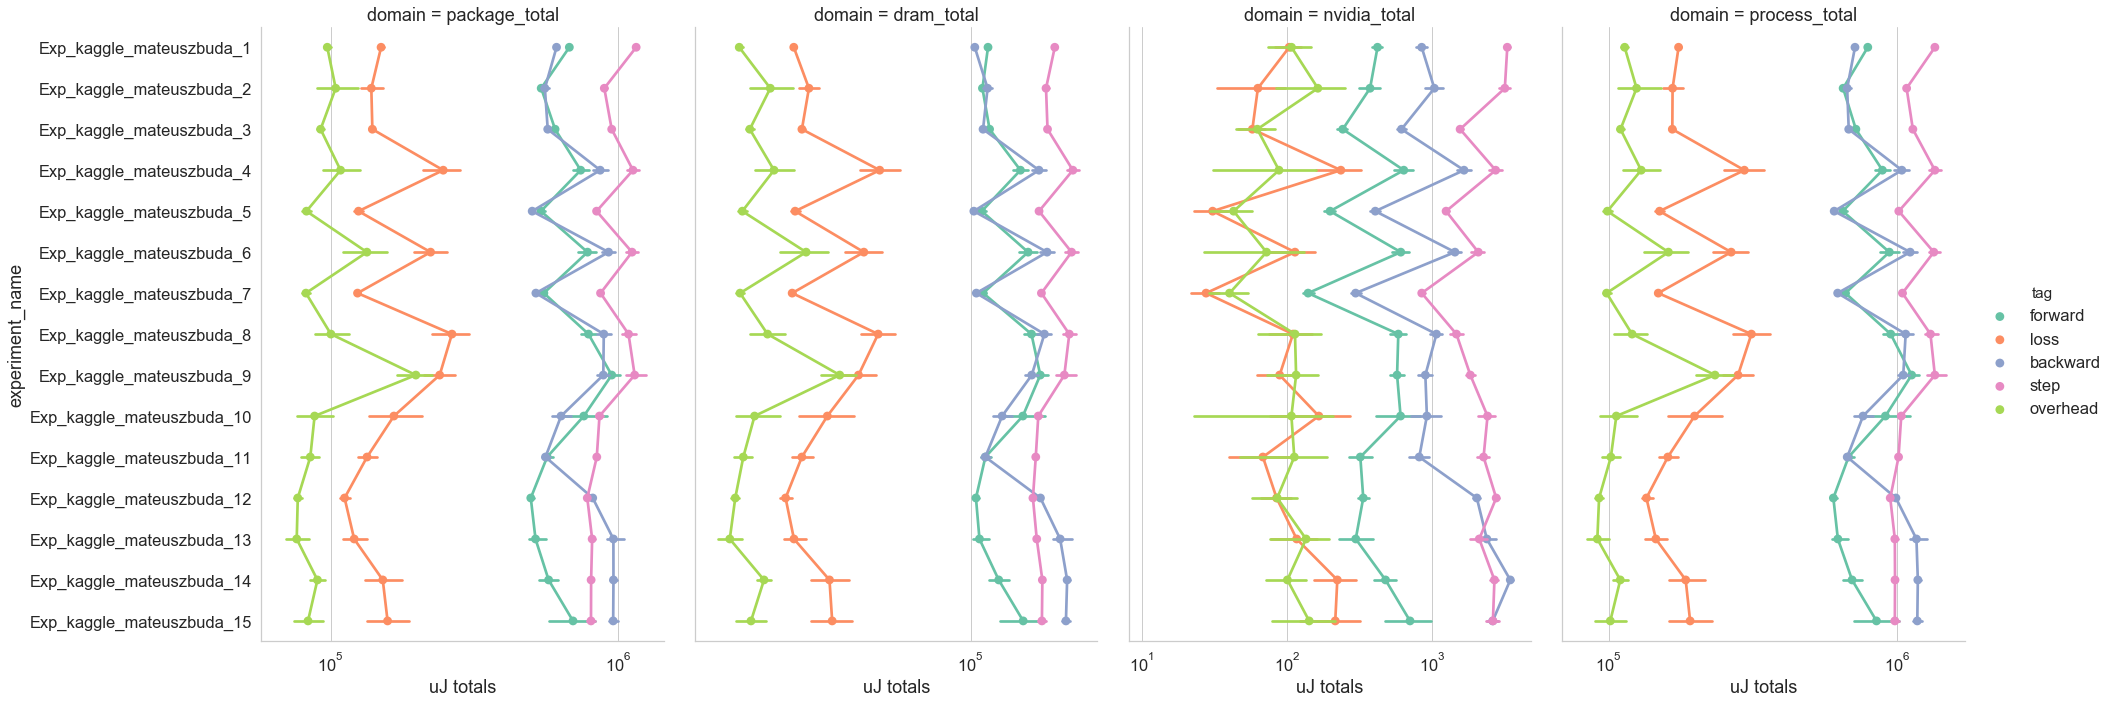

In [4]:
plot_df = joules_df_concat.copy()
plot_df = plot_df[plot_df['device']=='cuda']
plot_df = pd.melt(plot_df, id_vars=['experiment_name','device','tag','duration'], value_vars=['package_total','dram_total','nvidia_total','process_total'],
 var_name='domain', value_name='uJ totals')

sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y='experiment_name',x='uJ totals', hue='tag', col='domain', kind='point', data=plot_df, palette='Set2',height=10, aspect=0.7, sharex=False)
    g.set(xscale="log")

In [5]:
domain_names = ['package_total','dram_total','nvidia_total','process_total']

joules_df_melt = joules_df_concat.copy()
joules_df_melt = joules_df_melt[joules_df_melt['device']=='cuda']
joules_df_melt = pd.melt(joules_df_melt, id_vars=['experiment_name','device','tag','duration'], value_vars=['package_total','dram_total','nvidia_total','process_total'],
 var_name='domain', value_name='uJ totals')

total_joules = joules_df_melt[(joules_df_melt['domain'].isin(domain_names)) & (joules_df_melt['tag']!='overhead')]
overhead_joules = joules_df_melt[(joules_df_melt['domain'].isin(domain_names)) & (joules_df_melt['tag']=='overhead')]

# aggregate (mean) over measurement samples
total_joules = total_joules.groupby(['experiment_name','device','domain','tag']).mean().reset_index()
overhead_joules = overhead_joules.groupby(['experiment_name','device','domain','tag']).mean().reset_index()

# sum up consupmtion over all model OPs (tag) for a domain
total_joules = total_joules.groupby(['experiment_name','device','domain']).sum().reset_index()
overhead_joules = overhead_joules.groupby(['experiment_name','device',]).sum().reset_index()

# remove overhead consumptions as the estimated baseline from other processes on the node
# total_joules['uJ totals'] = total_joules['uJ totals'] - overhead_joules['uJ totals']

total_joules = pd.merge(total_joules,exp_config_df_concat,on=['experiment_name','device'])
total_joules.head()

,experiment_name,device,domain,duration,uJ totals,MAC,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,...,n_epochs,optimizer,params,proc,python_version,test_compute_time,test_perf,test_perf_selected,train_compute_time,valid_perf_selected
0,Exp_kaggle_mateuszbuda_1,cuda,dram_total,0.026128,4.363183e+05,12.13 GMac,0,0,0.0,0.0,...,20,adam,7.76 M,Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz,3.7.4.final.0 (64 bit),0.023897,60.458712,66.424563,72.467244,84.406171
1,Exp_kaggle_mateuszbuda_1,cuda,nvidia_total,0.026128,4.656532e+03,12.13 GMac,0,0,0.0,0.0,...,20,adam,7.76 M,Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz,3.7.4.final.0 (64 bit),0.023897,60.458712,66.424563,72.467244,84.406171
2,Exp_kaggle_mateuszbuda_1,cuda,package_total,0.026128,2.591688e+06,12.13 GMac,0,0,0.0,0.0,...,20,adam,7.76 M,Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz,3.7.4.final.0 (64 bit),0.023897,60.458712,66.424563,72.467244,84.406171
3,Exp_kaggle_mateuszbuda_1,cuda,process_total,0.026128,3.032663e+06,12.13 GMac,0,0,0.0,0.0,...,20,adam,7.76 M,Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz,3.7.4.final.0 (64 bit),0.023897,60.458712,66.424563,72.467244,84.406171
4,Exp_kaggle_mateuszbuda_10,cuda,dram_total,0.027879,4.811736e+05,12.13 GMac,0,0,0.0,NaN,...,20,adam,7.76 M,Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz,3.7.4.final.0 (64 bit),0.030222,64.919252,62.418329,17.701124,66.067722


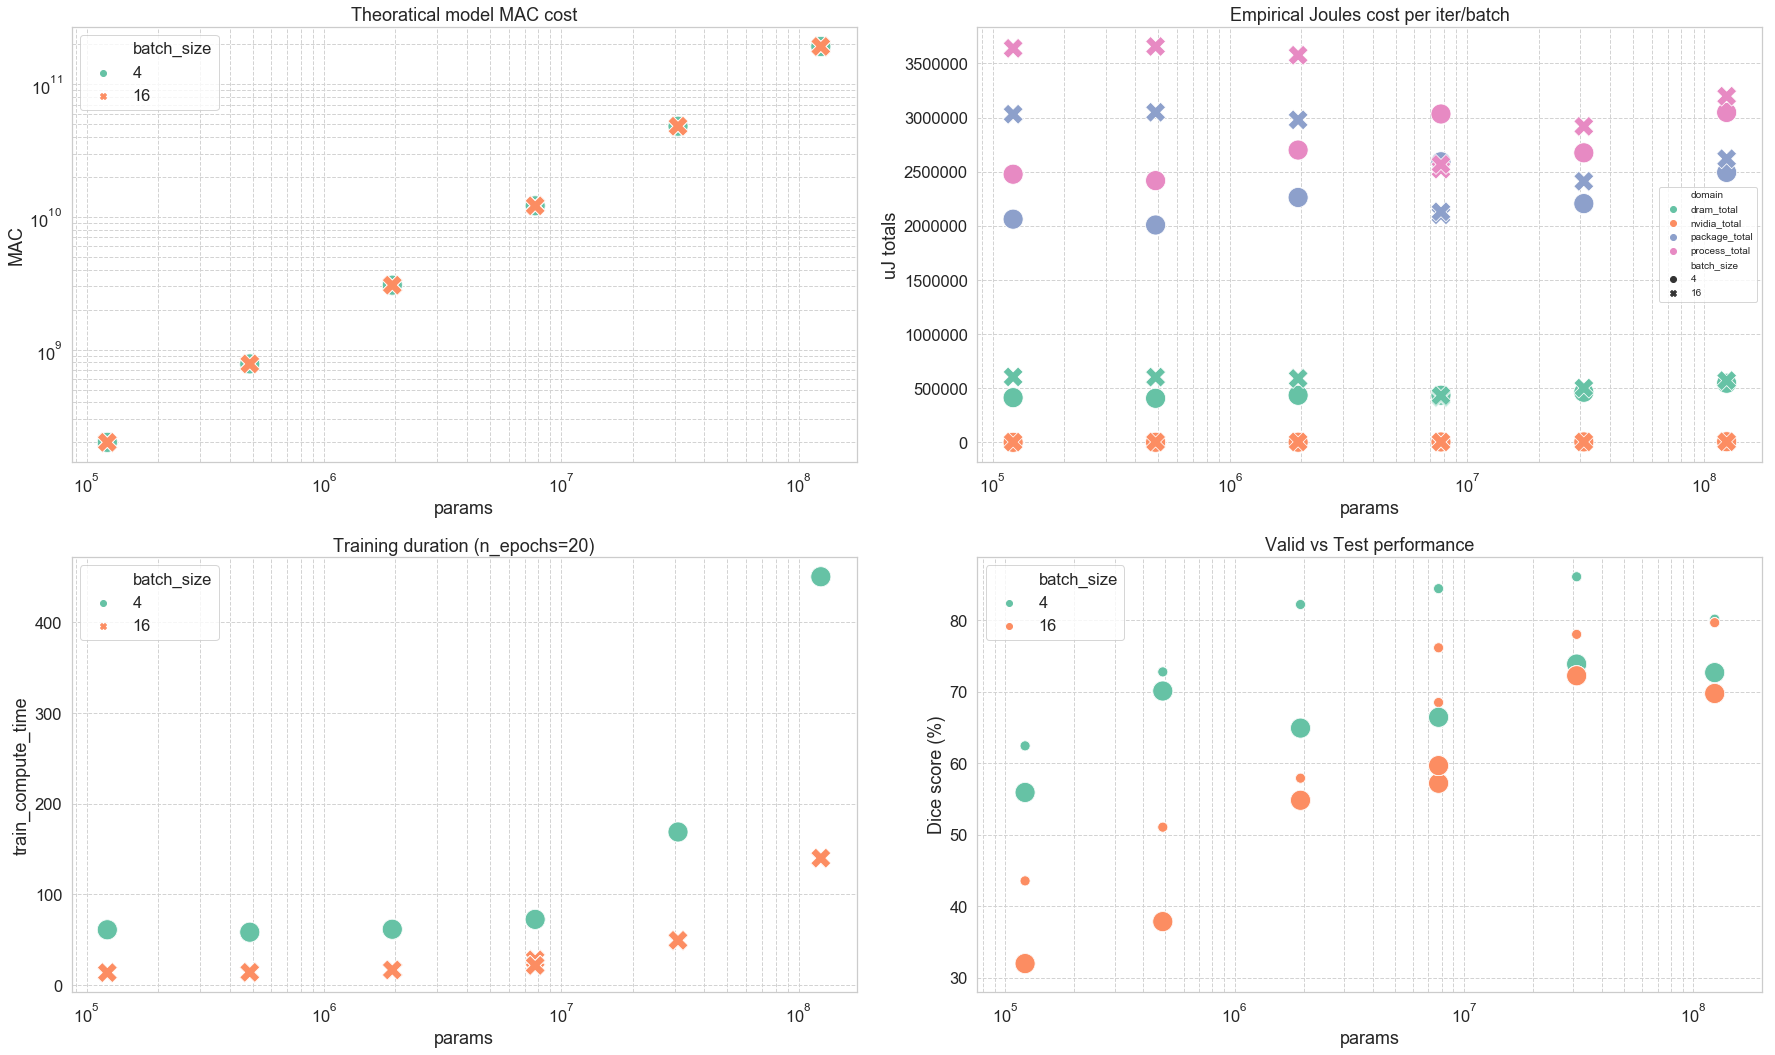

In [49]:
plot_df = total_joules.copy()
plot_df = plot_df[plot_df['batch_size'].isin([4,16])]
plot_df = convert_str_to_param_value(plot_df, 'params')
plot_df = convert_str_to_param_value(plot_df, 'MAC')
batch_hues = len(plot_df['batch_size'].unique())
size_level_dict =  dict(zip(np.sort(plot_df['batch_size'].unique()), [100,200,300,400]))

domain_hues = len(plot_df['domain'].unique())
sns.set(font_scale = 1.5)
batch_palette = sns.color_palette("Set2", batch_hues)
domain_palette = sns.color_palette("Set2", domain_hues)

with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(2,2,figsize=(25,15),sharex=False,sharey=False)

    # FLOPs
    ax = axes.ravel()[0]
    g = sns.scatterplot(x='params',y='MAC', hue='batch_size', style='batch_size', s=400, data=plot_df, palette=batch_palette,ax=ax) 
    g.set(xscale="log",yscale="log")
    g.grid(True,which="both",ls="--",c='lightgray')
    ax.set_title('Theoratical model MAC cost')

    # Energy
    ax = axes.ravel()[1]
    g = sns.scatterplot(x='params',y='uJ totals', hue='domain', style='batch_size', s=400, data=plot_df, palette=domain_palette,ax=ax)
    # g.set(xscale="log",yscale='log')
    g.set(xscale="log")
    ax.legend(loc=5,fontsize=10)
    g.grid(True,which="both",ls="--",c='lightgray')
    ax.set_title('Empirical Joules cost per iter/batch')

    # time
    ax = axes.ravel()[2]
    g = sns.scatterplot(x='params',y='train_compute_time', hue='batch_size', style='batch_size', s=400, data=plot_df, palette=batch_palette,ax=ax)
    
    # Consistently large ops for small batch sizes, but pretty similar across model sizes - does not explain joules preformance. 
    #g = sns.scatterplot(x='params',y='model_save_ops', hue='batch_size', style='batch_size', s=200, data=plot_df, palette=batch_palette,ax=ax)
    g.set(xscale="log")
    g.grid(True,which="both",ls="--",c='lightgray')
    ax.set_title('Training duration (n_epochs=20)')

    # Acc
    ax = axes.ravel()[3]
    g = sns.scatterplot(x='params',y='valid_perf_selected', hue='batch_size', s=100, legend=False, data=plot_df, palette=batch_palette,ax=ax)
    g.set(xscale="log")
    g.grid(True,which="both",ls="--",c='lightgray')
    ax.set_title('Dice')

    ax = axes.ravel()[3]
    g = sns.scatterplot(x='params',y='test_perf_selected', hue='batch_size', s=400, data=plot_df, palette=batch_palette,ax=ax)
    g.set(xscale="log")
    g.grid(True,which="both",ls="--",c='lightgray')
    ax.set_title('Valid vs Test performance')
    ax.set_ylabel('Dice score (%)')

plt.tight_layout()

### Duration vs joules per operation
- This cannot be split over domains
- backprop seems to slow down for large and xlarge models

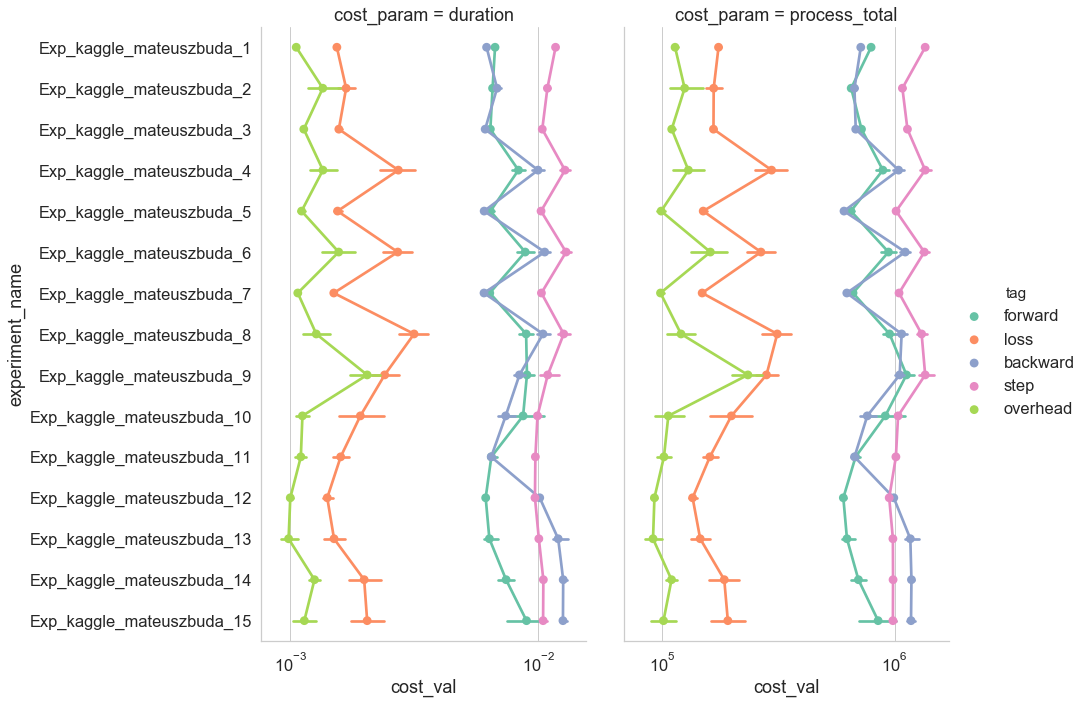

In [59]:
plot_df = joules_df_concat.copy()
plot_df = plot_df[plot_df['device']=='cuda']
plot_df = pd.melt(plot_df, id_vars=['experiment_name','device','tag'], value_vars=['duration','process_total'],
 var_name='cost_param', value_name='cost_val')

sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y='experiment_name',x='cost_val', hue='tag', col='cost_param' ,kind='point', data=plot_df, palette='Set2', sharex=False, height=10, aspect=0.7)
    g.set(xscale="log")



## MAC vs FLOPs

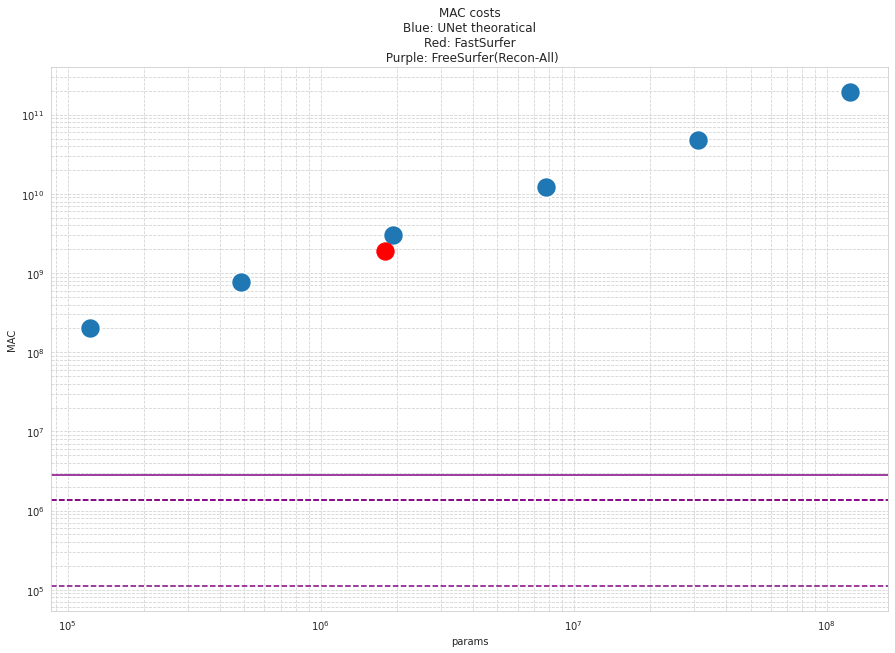

In [23]:
plot_df = exp_config_df_concat[exp_config_df_concat['batch_size']==4].copy()
plot_df = convert_str_to_param_value(plot_df, 'params')
plot_df = convert_str_to_param_value(plot_df, 'MAC')
batch_hues = len(plot_df['batch_size'].unique())
batch_palette = sns.color_palette("Set2", batch_hues)

# FreeSurfer - reconall
recon_csv = '{}results/preproc_costs/FS_reconall_flop_1.csv'.format(project_dir)
recon_df = pd.read_csv(recon_csv)

# FastSurfer
fastsurf_params = 1797386 # for a single model. This is instantiated 3 times for axial, coronal, and sagittal.
fastsurf_flops = 3761266571
fastsurf_macs = 0.5 * fastsurf_flops #https://github.com/sovrasov/flops-counter.pytorch/issues/16

with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(15,10),sharex=False,sharey=False)
    # FLOPs
    g = sns.scatterplot(x='params',y='MAC', s=400, data=plot_df, palette=batch_palette, ax=ax) 
    g.set(xscale="log",yscale="log")
    g.grid(True,which="both",ls="--",c='lightgray')
    g.set_title('MAC costs\nBlue: UNet theoratical\nRed: FastSurfer\n Purple: FreeSurfer(Recon-All)')

    g = ax.scatter(x=fastsurf_params,y=fastsurf_macs, s=300, c='red') 
    for count in recon_df['count'].values:
        g = ax.axhline(count, linestyle='--',c='purple')
    g = ax.axhline(np.sum(recon_df['count'].values), linestyle='-',c='purple')


In [19]:
recon_csv = '{}results/preproc_costs/FS_reconall_flop_1.csv'.format(project_dir)
recon_df = pd.read_csv(recon_csv)
recon_df

,Unnamed: 0,task,count
0,0,autorecon1,110781
1,1,autorecon2,1372448
2,2,autorecon3,1374088


In [20]:
FastSurf_csv = '{}results/preproc_costs/FastSurf_eval.csv'.format(project_dir)
FastSurf_df = pd.read_csv(FastSurf_csv)
FastSurf_df

,Unnamed: 0,task,DP,MAC,params
0,0,setup,[779],0,0
1,1,axial,[26351],0,0
2,2,Coronal,[26205],0,0
3,3,Sagittal,[26821],0,0
4,4,aggregate,[3761266571],0,0
5,5,cleanup,[0],0,0
6,6,save,[171],0,0


In [19]:
np.sum(recon_df['count'])

2857317